<a href="https://colab.research.google.com/github/windyrahayu45/Klasifikasi-Gambar-EuroSAT/blob/main/EuroSAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EuroSAT (Klasifikasi Lahan dari Citra Satelit)**

## **Objective:**   
Membangun sebuah model menggunakan CNN yang dapat mengklasifikasikan jenis lahan dari citra satelit.

## **Sumber Dataset**
https://www.kaggle.com/datasets/apollo2506/eurosat-dataset

# **Import Libraries**

In [100]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
import random
from glob import glob
import tensorflow as tf
import seaborn as sns
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [99]:
pip install tensorflowjs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


# **Upload Kaggle Token**

In [77]:
from google.colab import files

# Upload kaggle.json (Pilih file API Key yang sudah diunduh)
files.upload()



Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"windisrirahayu","key":"8ef7b0ca6dc7c15db9ee84c83af6347f"}'}

# **Install Kaggle**

In [78]:
!pip install kaggle


In [79]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"  # Untuk Google Colab


# **Download Dataset**

In [80]:
!kaggle datasets download -d apollo2506/eurosat-dataset


Dataset URL: https://www.kaggle.com/datasets/apollo2506/eurosat-dataset
License(s): CC0-1.0
eurosat-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


# **Ekstrak Dataset**

In [81]:
import zipfile

with zipfile.ZipFile("eurosat-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("eurosat_data")  # Ekstrak ke folder "eurosat_data"


# **Cek folder untuk jenis Dataset**

In [82]:
import os

data_path = "eurosat_data/EuroSAT"

# Cek apakah folder utama ada
if not os.path.exists(data_path):
    print(f"❌ Folder utama tidak ditemukan: {data_path}")
else:
    print(f"✅ Folder utama ditemukan: {data_path}")

    # Cek kategori dalam dataset
    categories = os.listdir(data_path)
    print("📂 Kategori dalam dataset:", categories)

    # Cek isi salah satu kategori
    sample_category = categories[0]  # Ambil kategori pertama
    sample_path = os.path.join(data_path, sample_category)
    if os.path.isdir(sample_path):
        print(f"📁 Isi folder {sample_category}:", os.listdir(sample_path)[:5])  # Tampilkan 5 file pertama


✅ Folder utama ditemukan: eurosat_data/EuroSAT
📂 Kategori dalam dataset: ['Residential', 'AnnualCrop', 'val', 'PermanentCrop', 'train', 'train.csv', 'Forest', 'SeaLake', 'Industrial', 'River', 'validation.csv', 'test', 'HerbaceousVegetation', 'label_map.json', 'Pasture', '.ipynb_checkpoints', 'test.csv', 'Highway']
📁 Isi folder Residential: ['Residential_1831.jpg', 'Residential_1475.jpg', 'Residential_940.jpg', 'Residential_588.jpg', 'Residential_1455.jpg']


# **Cek Data setiap folder jenis dataset**

In [83]:
import os

data_path = "eurosat_data/EuroSAT"

# Cek setiap kategori
for category in os.listdir(data_path):
    category_path = os.path.join(data_path, category)

    # Cek apakah ini folder
    if os.path.isdir(category_path):
        files = os.listdir(category_path)  # Ambil daftar file di dalam folder kategori
        print(f"📂 {category}: {len(files)} file ditemukan -> Contoh: {files[:5]}")


📂 Residential: 3000 file ditemukan -> Contoh: ['Residential_1831.jpg', 'Residential_1475.jpg', 'Residential_940.jpg', 'Residential_588.jpg', 'Residential_1455.jpg']
📂 AnnualCrop: 3000 file ditemukan -> Contoh: ['AnnualCrop_365.jpg', 'AnnualCrop_900.jpg', 'AnnualCrop_2405.jpg', 'AnnualCrop_2677.jpg', 'AnnualCrop_2540.jpg']
📂 val: 10 file ditemukan -> Contoh: ['Residential', 'AnnualCrop', 'PermanentCrop', 'Forest', 'SeaLake']
📂 PermanentCrop: 2500 file ditemukan -> Contoh: ['PermanentCrop_306.jpg', 'PermanentCrop_1980.jpg', 'PermanentCrop_2009.jpg', 'PermanentCrop_1321.jpg', 'PermanentCrop_1023.jpg']
📂 train: 10 file ditemukan -> Contoh: ['Residential', 'AnnualCrop', 'PermanentCrop', 'Forest', 'SeaLake']
📂 Forest: 3000 file ditemukan -> Contoh: ['Forest_1007.jpg', 'Forest_464.jpg', 'Forest_1602.jpg', 'Forest_2385.jpg', 'Forest_1226.jpg']
📂 SeaLake: 3000 file ditemukan -> Contoh: ['SeaLake_49.jpg', 'SeaLake_2109.jpg', 'SeaLake_2821.jpg', 'SeaLake_846.jpg', 'SeaLake_1529.jpg']
📂 Industrial

# **Split data menjadi train, test dan val**

In [91]:

# Path dataset asli
data_path = "eurosat_data/EuroSAT"

# Path tujuan
train_path = os.path.join(data_path, "train")
val_path = os.path.join(data_path, "val")
test_path = os.path.join(data_path, "test")

# Buat folder train, val, test jika belum ada
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Set rasio pembagian dataset
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Cek kategori yang tersedia
categories = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d)) and d not in ["train", "val", "test", ".ipynb_checkpoints"]]
print("📂 Kategori ditemukan:", categories)

for category in categories:
    category_path = os.path.join(data_path, category)

    # Ambil semua gambar (termasuk dalam sub-folder)
    images = glob(os.path.join(category_path, "**", "*.*"), recursive=True)

    if not images:
        print(f"⚠️ Tidak ada gambar dalam kategori: {category}")
        continue

    # Acak urutan gambar
    random.shuffle(images)

    # Hitung jumlah data
    total_images = len(images)
    train_split = int(total_images * train_ratio)
    val_split = int(total_images * val_ratio)

    # Bagi dataset
    train_images = images[:train_split]
    val_images = images[train_split:train_split + val_split]
    test_images = images[train_split + val_split:]

    # Fungsi untuk memindahkan gambar
    def move_files(image_list, dest_folder):
        dest_label_folder = os.path.join(dest_folder, category)
        os.makedirs(dest_label_folder, exist_ok=True)
        for img_path in image_list:
            img_name = os.path.basename(img_path)
            shutil.move(img_path, os.path.join(dest_label_folder, img_name))

    # Pindahkan gambar
    move_files(train_images, train_path)
    move_files(val_images, val_path)
    move_files(test_images, test_path)

    print(f"✅ {category}: {len(train_images)} train, {len(val_images)} val, {len(test_images)} test")

print("\n🎉 Pembagian dataset selesai!")


📂 Kategori ditemukan: ['Residential', 'AnnualCrop', 'PermanentCrop', 'Forest', 'SeaLake', 'Industrial', 'River', 'HerbaceousVegetation', 'Pasture', 'Highway']
⚠️ Tidak ada gambar dalam kategori: Residential
⚠️ Tidak ada gambar dalam kategori: AnnualCrop
⚠️ Tidak ada gambar dalam kategori: PermanentCrop
⚠️ Tidak ada gambar dalam kategori: Forest
⚠️ Tidak ada gambar dalam kategori: SeaLake
⚠️ Tidak ada gambar dalam kategori: Industrial
⚠️ Tidak ada gambar dalam kategori: River
⚠️ Tidak ada gambar dalam kategori: HerbaceousVegetation
⚠️ Tidak ada gambar dalam kategori: Pasture
⚠️ Tidak ada gambar dalam kategori: Highway

🎉 Pembagian dataset selesai!


#**Menampilkan Gambar Sampel dari Setiap Kelas**

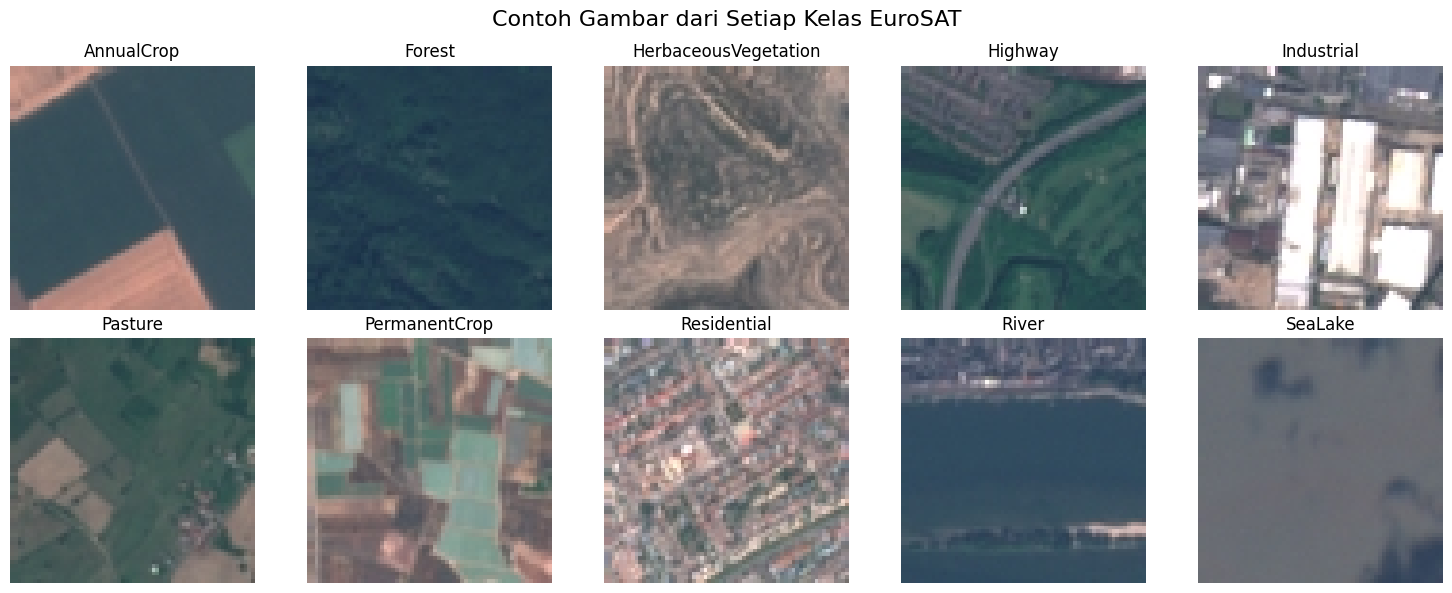

In [96]:


# Path dataset (train set)
dataset_path = "eurosat_data/EuroSAT/train"

# Ambil daftar kelas
class_names = sorted(os.listdir(dataset_path))

# Buat plot gambar untuk setiap kelas
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 baris, 5 kolom (karena ada 10 kelas)
fig.suptitle("Contoh Gambar dari Setiap Kelas EuroSAT", fontsize=16)

for ax, class_name in zip(axes.flat, class_names):
    class_path = os.path.join(dataset_path, class_name)

    # Ambil satu gambar dari kelas ini
    img_filename = np.random.choice(os.listdir(class_path))  # Pilih gambar secara acak
    img_path = os.path.join(class_path, img_filename)

    # Load dan tampilkan gambar dengan mpimg
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis("off")  # Sembunyikan axis

plt.tight_layout()
plt.show()



#**Plot Distribusi Gambar di Setiap Kelas**

<ipython-input-93-f3df74f54317>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


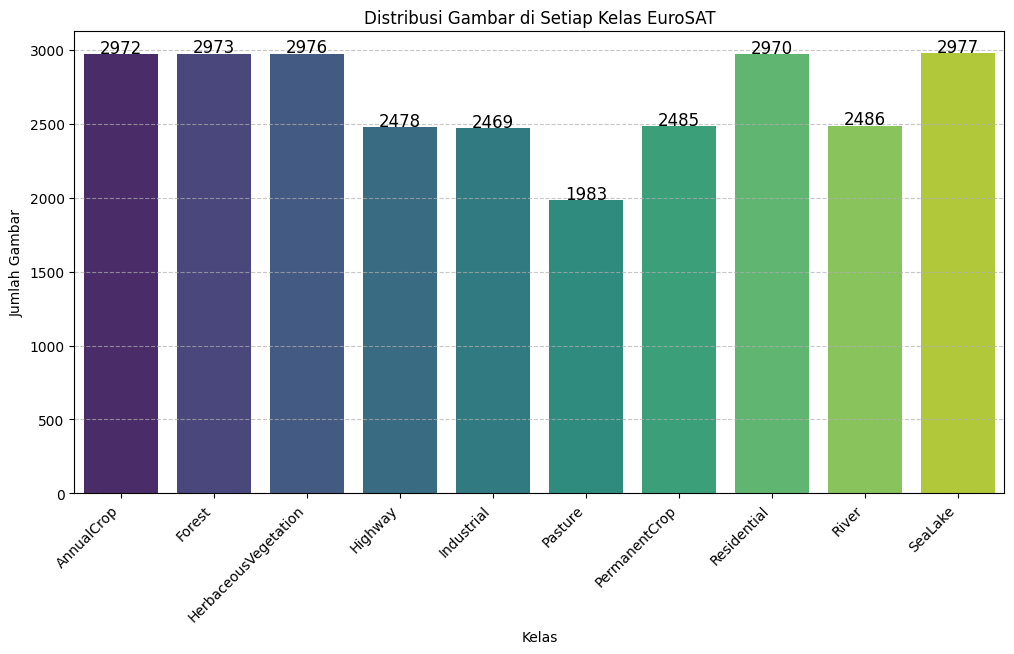

In [93]:
# Path dataset (gunakan train set untuk melihat distribusi utama)
dataset_path = "eurosat_data/EuroSAT/train"

# Ambil daftar kelas
class_names = sorted(os.listdir(dataset_path))

# Hitung jumlah gambar di setiap kelas
class_counts = {class_name: len(os.listdir(os.path.join(dataset_path, class_name))) for class_name in class_names}

# Plot distribusi
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")

plt.xticks(rotation=45, ha="right")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.title("Distribusi Gambar di Setiap Kelas EuroSAT")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Tampilkan angka di atas tiap batang
for i, count in enumerate(class_counts.values()):
    plt.text(i, count + 10, str(count), ha='center', fontsize=12)

plt.show()


#**Augmentation dan Pemodelan CNN**

In [87]:


# Path dataset
dataset_path = "eurosat_data/EuroSAT"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

# Image dimensions
IMG_SIZE = (64, 64)  # Ukuran gambar EuroSAT
BATCH_SIZE = 32

# Augmentasi Data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset dengan ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# **Membangun CNN dari awal dengan Conv2D & Pooling Layer**
model = Sequential([
    # Layer Konvolusi 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer Konvolusi 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Layer Konvolusi 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten dan Fully Connected Layer
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,  # Bisa ditambah jika akurasi belum cukup
    verbose=1
)

# Evaluasi model pada test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Fine-tuning jika akurasi belum mencapai 95%
if test_acc < 0.95:
    print("Melakukan fine-tuning...")

    # Training tambahan dengan learning rate lebih kecil
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history_finetune = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,  # Tambah 10 epoch lagi
        verbose=1
    )

    # Evaluasi ulang setelah fine-tuning
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Final Test Accuracy: {test_acc * 100:.2f}%")


Found 26769 images belonging to 10 classes.
Found 7317 images belonging to 10 classes.
Found 7291 images belonging to 10 classes.
Epoch 1/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 267s 310ms/step - accuracy: 0.3167 - loss: 1.7340 - val_accuracy: 0.5607 - val_loss: 1.1343
Epoch 2/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 248s 296ms/step - accuracy: 0.5931 - loss: 1.0941 - val_accuracy: 0.6842 - val_loss: 0.8865
Epoch 3/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 254s 304ms/step - accuracy: 0.6747 - loss: 0.8952 - val_accuracy: 0.6721 - val_loss: 0.9364
Epoch 4/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 249s 298ms/step - accuracy: 0.7219 - loss: 0.7860 - val_accuracy: 0.6951 - val_loss: 0.8244
Epoch 5/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 258s 308ms/step - accuracy: 0.7393 - loss: 0.7342 - val_accuracy: 0.7668 - val_loss: 0.6528
Epoch 6/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 248s 297ms/step - accuracy: 0.7587 - loss: 0.6903 - val_accuracy: 0.8099 - val_loss: 0.5188
Epoch 7/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 251s 299ms/step - accuracy: 0.7766 - l

#**Plot Akurasi dan Loss**

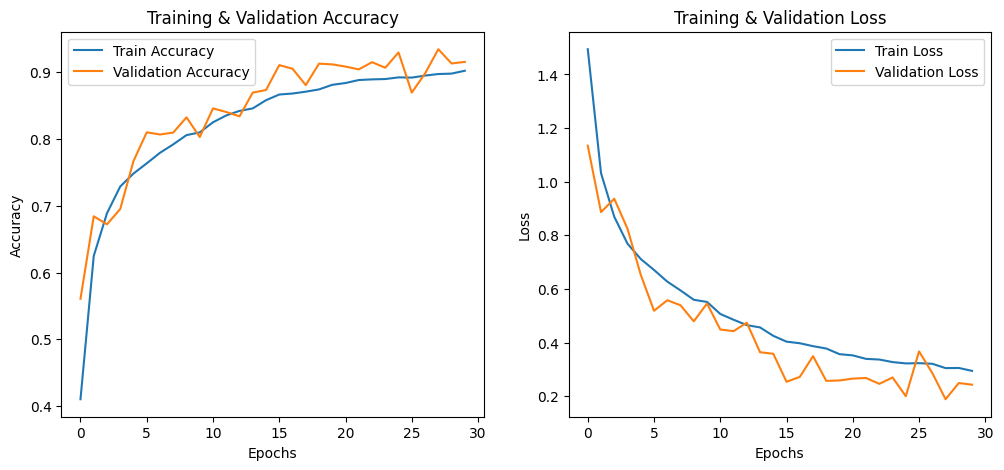

In [97]:
# Plot Akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()

#**Save Model**

In [123]:
# Pastikan model sudah ada
if 'model' not in locals():
    raise ValueError("❌ Model belum dibuat atau dilatih! Jalankan proses training dulu.")


In [130]:
# Pastikan folder ada
saved_model_dir = "submission1/saved_model"
os.makedirs(saved_model_dir, exist_ok=True)

# Simpan model dengan export() untuk format SavedModel
model.export(saved_model_dir)

print("✅ Model berhasil disimpan dalam format SavedModel!")


Saved artifact at 'submission1/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='keras_tensor_12')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132080770977808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132080770980112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132080770976464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132080770980688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132080770979920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132080770981456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132080770980880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132080770982224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132080770978960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132080770980304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13208

In [127]:
# Buat folder untuk model TF-Lite
tflite_model_dir = "submission1/tflite"
os.makedirs(tflite_model_dir, exist_ok=True)

# Konversi model ke format TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Simpan model TF-Lite
tflite_model_path = os.path.join(tflite_model_dir, "model.tflite")
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

# Simpan label (jika ada)
labels = ["Class_0", "Class_1", "Class_2", "Class_3", "Class_4", "Class_5", "Class_6", "Class_7", "Class_8", "Class_9"]
with open(os.path.join(tflite_model_dir, "label.txt"), "w") as f:
    f.write("\n".join(labels))

print("✅ Model berhasil dikonversi ke TF-Lite!")


✅ Model berhasil dikonversi ke TF-Lite!


In [129]:
import tensorflowjs as tfjs

# Pastikan model memiliki input layer yang jelas
new_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(64, 64, 3)),  # Sesuaikan dengan dataset
    *model.layers  # Tambahkan semua layer dari model sebelumnya
])

# Buat folder untuk model TFJS
tfjs_model_dir = "submission1/tfjs_model"
os.makedirs(tfjs_model_dir, exist_ok=True)

# Simpan model dalam format TensorFlow.js
tfjs.converters.save_keras_model(new_model, tfjs_model_dir)

print("✅ Model berhasil dikonversi ke TensorFlow.js!")


failed to lookup keras version from the file,
    this is likely a weight only file
✅ Model berhasil dikonversi ke TensorFlow.js!


In [131]:
import shutil

# Buat file zip dari folder submission1
shutil.make_archive("submission1", 'zip', "submission1")

# Download file zip
from google.colab import files
files.download("submission1.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>